1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

/tmp/ipykernel_11787/36498270.py:23: RuntimeWarning: divide by zero encountered in log2
  return -tau*(np.log2(1 - z))


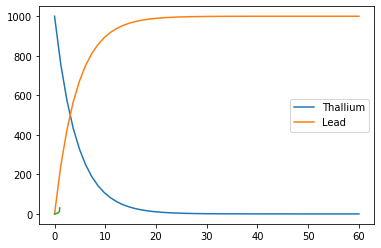

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
tau=3.052
t=np.linspace(0,60)
Tl = 1000*(2**((-1)*(t)/tau))
Pb = 1000-Tl
plt.plot(t,Tl,label="Thallium")
plt.plot(t,Pb,label="Lead")
plt.legend(loc="best")


def pdf(t):
    return (2**(-t/tau))*(math.log(2)/tau)

def cdf(t):
    return 1 - 2**(-t/tau)

def icdf(z):
    return -tau*(np.log2(1 - z))

z=np.linspace(0,1,1000)

plt.plot(z, icdf(z))


2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [2]:
Z=79
e=1.6 * np.power(1/10,19)
E=7.7 * np.power(10,6) *e
e0=8.85 * np.power(1/10,12)
a0=5.29 * np.power(1/10,11)
sigma=a0/100
N=1000000

x,y = np.random.multivariate_normal([0,0], [[sigma**2,0],[0,sigma**2]], N).T
b=np.sqrt(x**2 +y**2 )
theta = 2*np.arctan((Z*e**2)/(2*np.pi*E*e0)/b )

count=0
for i in range(len(theta)):
    if theta[i]>np.pi/2 :
        count+=1
print("The fraction of particles that bounce back is", count/N*100)     

The fraction of particles that bounce back is 0.1583


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [4]:
from scipy import integrate

def f(x):
    return (np.sin(1/(x*(2-x))))**2

N=100000
I, e = integrate.quad(f, 0, 2)

 # Hit/Miss method
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x):
        count+=1
I_HM=2*count/N
print("The integral with the Hit/Mass method is",I_HM)
print("The error with the Hit/Mass methd  is",abs(I-I_HM)/I)
print("")
 #Mean Value method
x = np.random.uniform(0, 2, N)
fsum= 0
for i in range(len(x)):
    fsum += f(x[i])
I_MV = (2-0)/N *fsum
print("The integral with the Mean Value method is",I_MV)
print("The error with the Mean Value methd  is ",abs(I-I_MV)/I)

/tmp/ipykernel_11787/75053600.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I, e = integrate.quad(f, 0, 2)


The integral with the Hit/Mass method is 1.45424
The error with the Hit/Mass methd  is 0.0017581253387353745

The integral with the Mean Value method is 1.4528698322444675
The error with the Mean Value methd  is  0.0008142806623533692


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [5]:
def f(x,y):
    if x**2 + y**2 <= 1:
        return 1
    else: 
        return 0
N=1000000
fsum=0
for i in range(N):
    x=np.random.random()
    y=np.random.random()
    if f(x,y)==1:
        fsum+=1
I=(2**2)/N*fsum
print("The area of a 2D sphere ",I)
 
 #For 10 dimentions
def f(x0,x1,x2,x3,x4,x5,x6,x7,x8,x9):
    if x0**2+x1**2+x2**2+x3**2+x4**2+x5**2+x6**2+x7**2+x8**2+x9**2 <= 1:
        return 1
    else: 
        return 0

fsum=0
for i in range(N):
    x0=np.random.random()
    x1=np.random.random()
    x2=np.random.random()
    x3=np.random.random()
    x4=np.random.random()
    x5=np.random.random()
    x6=np.random.random()
    x7=np.random.random()
    x8=np.random.random()
    x9=np.random.random()
    if f(x0,x1,x2,x3,x4,x5,x6,x7,x8,x9)==1:
        fsum+=1
I=(2**10)/N*fsum
print("The area of a 10D sphere ",I)
 

The area of a 2D sphere  3.139804
The area of a 10D sphere  2.623488


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [6]:
N = 1000000

def f(x):
    return (x**-0.5)/(np.exp(x)+1)
def w(x):
    return 1/x**0.5
 
x = np.random.uniform(0,1, N)
sum_fw= 0
for i in range(N):
    sum_fw += f(x[i])/w(x[i])
I_w,err_w=integrate.quad(w, 0, 1)
I = sum_fw /N * I_w
print("The MC integration with Importance Sampling is",I)

 # integration with out sampling
s=0
for i in range (N):
    s+=f(x[i])
II=(1-0)/N*s
print("The MC integration is",II)

 # integration with scipy
III, e = integrate.quad(f, 0, 1)
print("The Scipy integration is ",III)

The MC integration with Importance Sampling is 0.7597056828229666
The MC integration is 0.8496265696623971
The Scipy integration is  0.8389329600133838
